<a href="https://colab.research.google.com/github/ilhamdwiprastyo/Sentiment-Analysis-with-XLNet-and-BERT-Model-with-Pytorch/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.2MB/s 
     |████████████████████████████████| 901kB 55.5MB/s 
     |████████████████████████████████| 3.3MB 63.9MB/s 


In [ ]:
#@title Setup & Config
import transformers

from transformers import ElectraTokenizer, ElectraModel, AutoModel, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1H4o_iaTuTKhBJkr8fSpGvBWJK1kKApxL

Downloading...
From: https://drive.google.com/uc?id=1H4o_iaTuTKhBJkr8fSpGvBWJK1kKApxL
To: /content/Clean_Dataset_TripAdvisor.zip
23.1MB [00:00, 73.6MB/s]


In [ ]:
!unzip /content/Clean_Dataset_TripAdvisor.zip

Archive:  /content/Clean_Dataset_TripAdvisor.zip
  inflating: Clean_Dataset_TripAdvisor.csv  


In [ ]:
df = pd.read_csv('Clean_Dataset_TripAdvisor.csv')
df

,Review_Text,text bersih,text bersih banget,text bersih poll banget,Rating
0,Saya menginap di Alila seminyak selama 3 malam...,saya menginap di alila seminyak selama malam s...,menginap alila seminyak malam menginap kamar d...,inap alila minyak malam inap kamar lantai lobb...,5
1,"Bagian terbaik, saya bisa membuka seluruh jend...",bagian terbaik saya bisa membuka seluruh jende...,terbaik membuka jendela menghadap laut menikma...,baik buka jendela hadap laut nikmat debur omba...,5
2,"Dalam keadaan pandemi seperti ini,performa Hot...",dalam keadaan pandemi seperti ini performa hot...,pandemi performa memuaskan segi kebersihan pel...,pandemi performa muas segi bersih layan fasili...,5
3,Lokasi hotel persis di pinggir pantai dan bisa...,lokasi hotel persis di pinggir pantai dan bisa...,lokasi persis pinggir pantai menikmati sunset ...,lokasi persis pinggir pantai nikmat sunset kam...,5
4,View sunsetnya bagus! Makanannya enak dan pela...,view sunsetnya bagus makanannya enak dan pelay...,view sunsetnya bagus makanannya enak pelayanan...,view sunsetnya bagus makan enak layan server t...,5
...,...,...,...,...,...
86507,Membaca dari agoda untuk menyediakan informasi...,membaca dari agoda untuk menyediakan informasi...,membaca agoda menyediakan informasi check in m...,baca agoda sedia informasi check in rencana ku...,1
86508,Kami mengunjungi u pasha dengan keluarga kami ...,kami mengunjungi u pasha dengan keluarga kami ...,mengunjungi u pasha keluarga kecewa fasilitas ...,unjung u pasha keluarga kecewa fasilitas layan...,1
86509,Kami pergi ke seminyak pada bulan madu kami di...,kami pergi ke seminyak pada bulan madu kami di...,pergi seminyak madu tidak layak bintang sulit ...,pergi minyak madu tidak layak bintang sulit pe...,2
86510,pertama-tama kamar teman saya adalah besar dan...,pertama tama kamar teman saya adalah besar dan...,tama kamar teman indah kesalahan keluhan memil...,tama kamar teman indah salah keluh milik sarap...,2


In [ ]:
# df=df.drop_duplicates(subset="text bersih poll banget")
df=df.dropna()
df=df.reset_index(drop=True)
df

,Review_Text,text bersih,text bersih banget,text bersih poll banget,Rating
0,Saya menginap di Alila seminyak selama 3 malam...,saya menginap di alila seminyak selama malam s...,menginap alila seminyak malam menginap kamar d...,inap alila minyak malam inap kamar lantai lobb...,5
1,"Bagian terbaik, saya bisa membuka seluruh jend...",bagian terbaik saya bisa membuka seluruh jende...,terbaik membuka jendela menghadap laut menikma...,baik buka jendela hadap laut nikmat debur omba...,5
2,"Dalam keadaan pandemi seperti ini,performa Hot...",dalam keadaan pandemi seperti ini performa hot...,pandemi performa memuaskan segi kebersihan pel...,pandemi performa muas segi bersih layan fasili...,5
3,Lokasi hotel persis di pinggir pantai dan bisa...,lokasi hotel persis di pinggir pantai dan bisa...,lokasi persis pinggir pantai menikmati sunset ...,lokasi persis pinggir pantai nikmat sunset kam...,5
4,View sunsetnya bagus! Makanannya enak dan pela...,view sunsetnya bagus makanannya enak dan pelay...,view sunsetnya bagus makanannya enak pelayanan...,view sunsetnya bagus makan enak layan server t...,5
...,...,...,...,...,...
86506,Membaca dari agoda untuk menyediakan informasi...,membaca dari agoda untuk menyediakan informasi...,membaca agoda menyediakan informasi check in m...,baca agoda sedia informasi check in rencana ku...,1
86507,Kami mengunjungi u pasha dengan keluarga kami ...,kami mengunjungi u pasha dengan keluarga kami ...,mengunjungi u pasha keluarga kecewa fasilitas ...,unjung u pasha keluarga kecewa fasilitas layan...,1
86508,Kami pergi ke seminyak pada bulan madu kami di...,kami pergi ke seminyak pada bulan madu kami di...,pergi seminyak madu tidak layak bintang sulit ...,pergi minyak madu tidak layak bintang sulit pe...,2
86509,pertama-tama kamar teman saya adalah besar dan...,pertama tama kamar teman saya adalah besar dan...,tama kamar teman indah kesalahan keluhan memil...,tama kamar teman indah salah keluh milik sarap...,2


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return None
  else: 
    return 1

df['sentiment'] = df.Rating.apply(to_sentiment)
df=df.dropna()
df=df.reset_index(drop=True)

In [ ]:
class_names = ['negative', 'positive']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
# PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p1'
# PRE_TRAINED_MODEL_NAME = 'sarahlintang/IndoBERT'
# PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

In [ ]:
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# tokenizer = XLNetTokenizer.from_pretrained('huseinzol05/xlnet-base-bahasa-cased', do_lower_case = False)
tokenizer = ElectraTokenizer.from_pretrained('huseinzol05/electra-base-discriminator-bahasa-cased', do_lower_case = False)

In [ ]:
# input_txt = "Text data"
# encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation = True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((56757, 6), (12162, 6), (12163, 6))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df['text bersih poll banget'].to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wcf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wco = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda(),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda())


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            if step in self.effective_step:
                outputs.append(x)

        return outputs, (x, new_c)


if __name__ == '__main__':
    # gradient check
    convlstm = ConvLSTM(input_channels=512, hidden_channels=[128, 64, 64, 32, 32], kernel_size=3, step=5,
                        effective_step=[4]).cuda()
    loss_fn = torch.nn.MSELoss()

    input = Variable(torch.randn(1, 512, 64, 32)).cuda()
    target = Variable(torch.randn(1, 32, 64, 32)).double().cuda()

    output = convlstm(input)
    output = output[0][0].double()
    res = torch.autograd.gradcheck(loss_fn, (output, target), eps=1e-6, raise_exception=True)
    print(res)

True


In [ ]:
x = torch.rand((32, 10, 64, 128, 128))

In [ ]:
convlstm = ConvLSTM(64, 16, (3,3), 1, True, True, False)
_, last_states = convlstm(x)
h = last_states[0][0]

In [ ]:
h.size()

torch.Size([32, 16, 128, 128])

In [ ]:
clstm = ConvLSTM(input_channels=768, hidden_channels=[128, 64, 100], kernel_size=3, step=9, effective_step=[2, 4, 8])

In [ ]:
co_model = ConvLSTM(input_dim=768,
                 hidden_dim=[64, 100, 128],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

In [ ]:
input_ids

tensor([[    5,     5,     5,  ...,  4205,     4,     3],
        [    5,     5,     5,  ...,  9639,     4,     3],
        [    5,     5,     5,  ...,  3655,     4,     3],
        ...,
        [    5,     5,     5,  ...,   352,     4,     3],
        [    5,     5,     5,  ..., 25033,     4,     3],
        [    5,     5,     5,  ...,   451,     4,     3]], device='cuda:0')

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    # self.colstm = ConvLSTM(input_dim=768,
    #              hidden_dim=[64, 100, 128],
    #              kernel_size=(3, 3),
    #              num_layers=3,
    #              batch_first=True,
    #              bias=True,
    #              return_all_layers=False)
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
# ELECTRA
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    # self.colstm = ConvLSTM(input_dim=768,
    #              hidden_dim=[64, 100, 128],
    #              kernel_size=(3, 3),
    #              num_layers=3,
    #              batch_first=True,
    #              bias=True,
    #              return_all_layers=False)
    self.elc = ElectraModel.from_pretrained('huseinzol05/electra-base-discriminator-bahasa-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.elc.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.elc(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at huseinzol05/electra-base-discriminator-bahasa-cased were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 100])
torch.Size([32, 100])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

ValueError: ignored

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
from sklearn import metrics
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  # acc = 0
  # counter = 0
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    # targets = targets.cpu().detach().numpy()
    # prediction = preds.cpu().detach().numpy()
    # accuracy = metrics.roc_auc_score(targets, prediction)

    # acc += accuracy
    # counter += 1
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)
  # return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  # acc = 0
  # counter = 0
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      # targets = targets.cpu().detach().numpy()
      # prediction = preds.cpu().detach().numpy()
      # accuracy = metrics.roc_auc_score(targets, prediction)

      correct_predictions += torch.sum(preds == targets)

      # acc += accuracy
      # counter += 1
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)
  # return acc / counter, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_8.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


ValueError: ignored

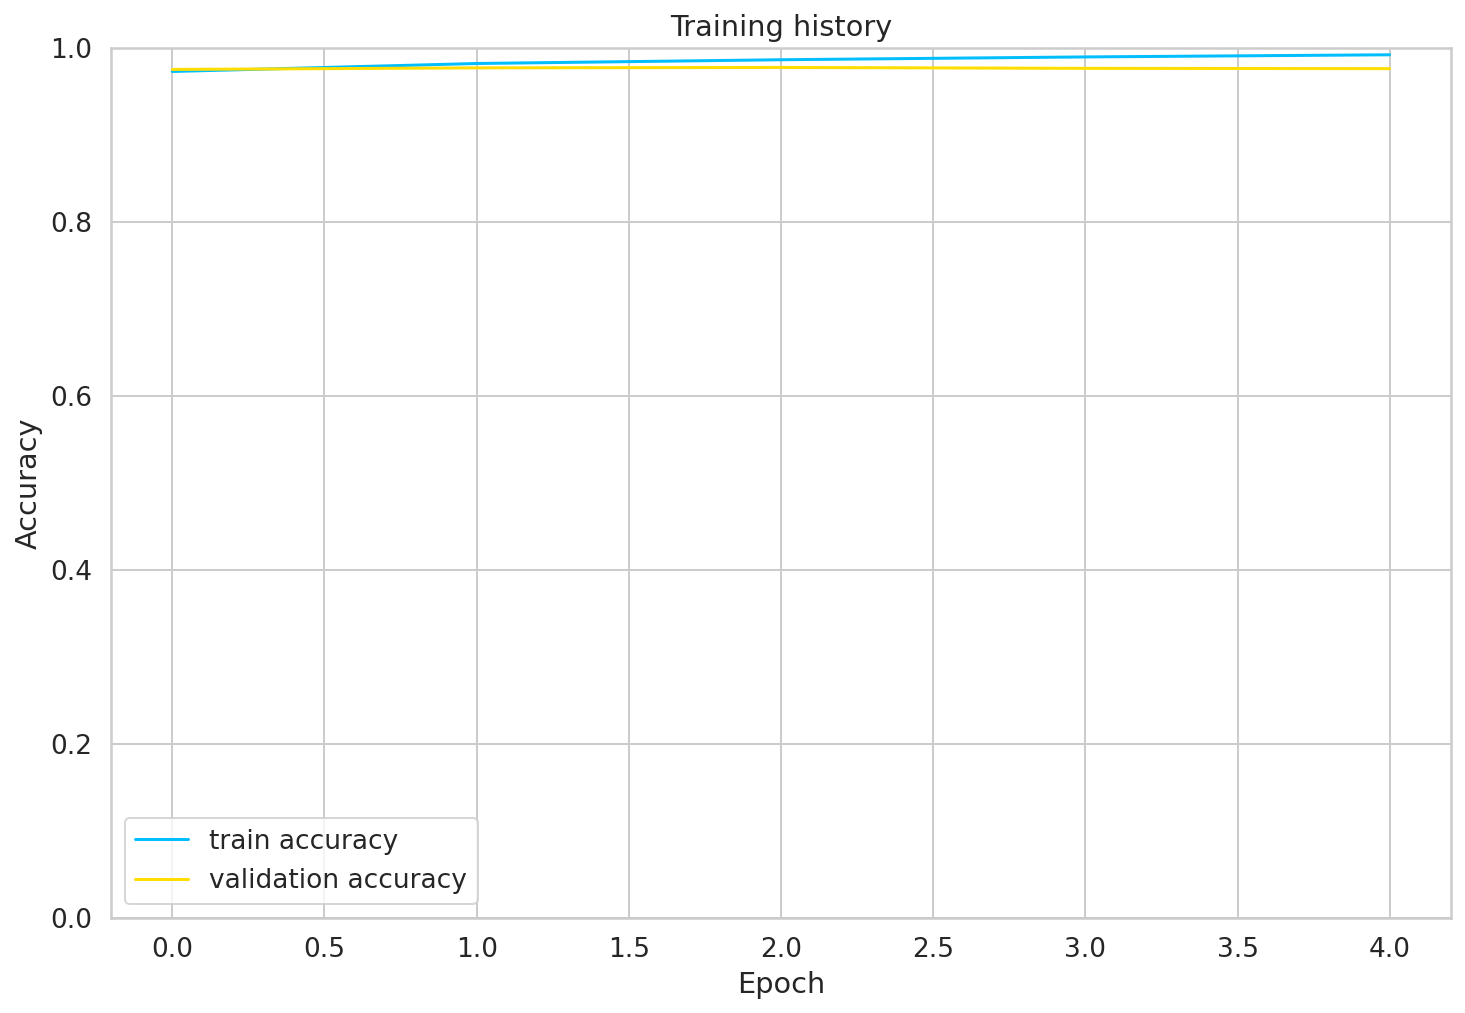

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Load Model

In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

# Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9753116797900262

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.56      0.64       470
    positive       0.98      0.99      0.99     11693

    accuracy                           0.98     12163
   macro avg       0.86      0.78      0.81     12163
weighted avg       0.97      0.98      0.97     12163



In [ ]:
print(metrics.precision_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.9825482887156896
0.9871898540239179
0.9752528159171258
0.9918754810570427
0.7767888043583084


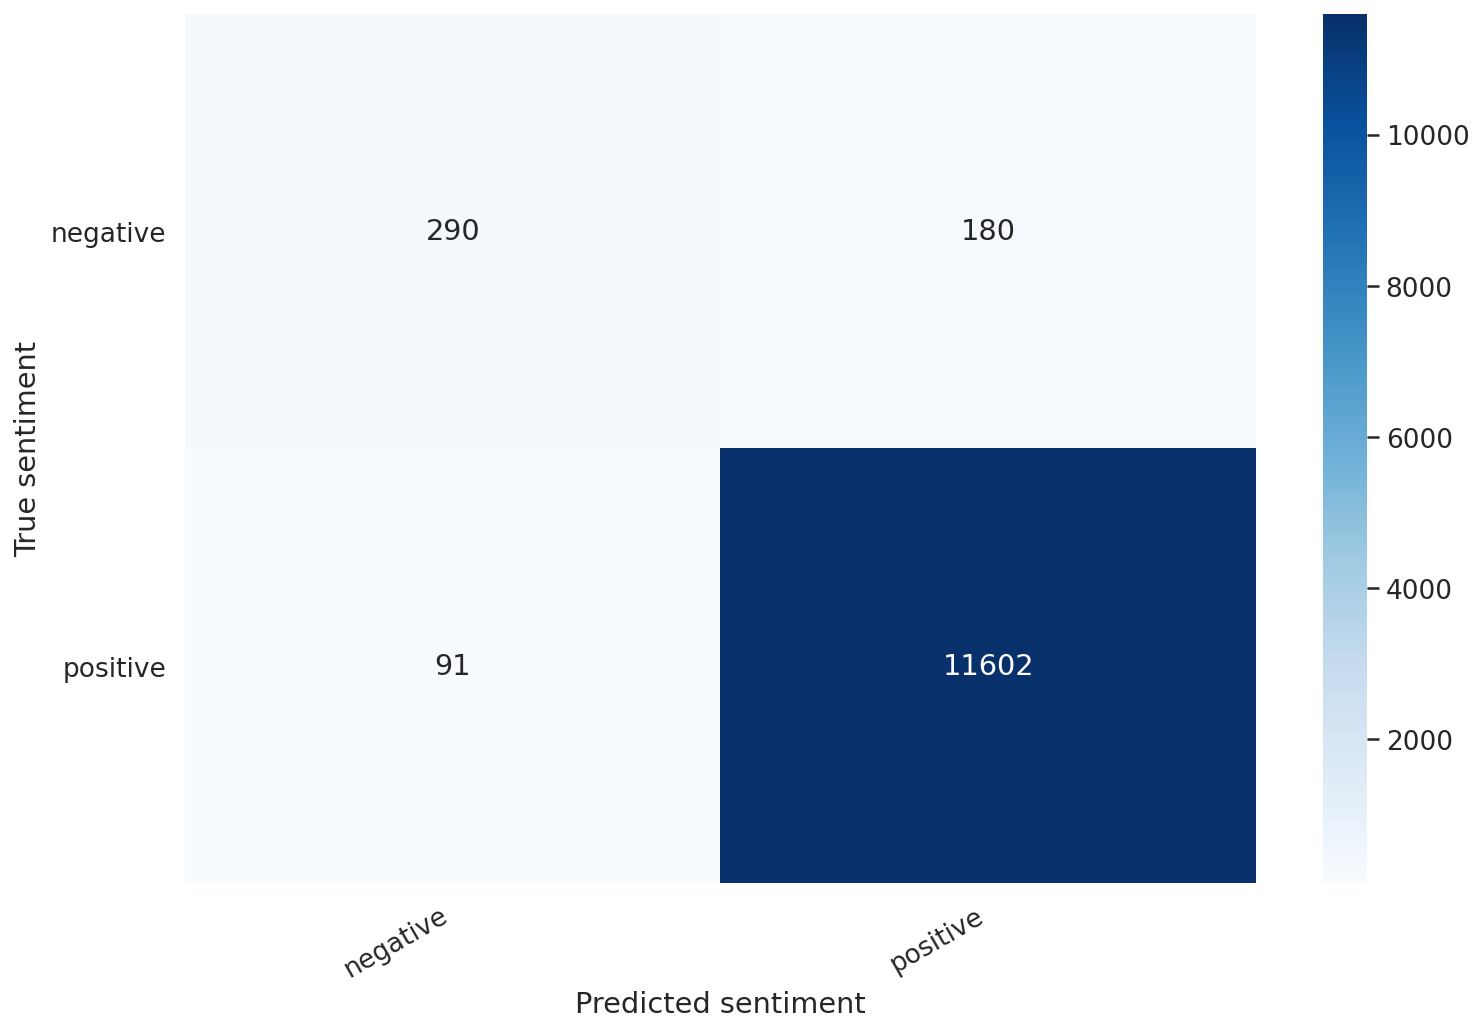

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

tinggal marriott batu menit jalan sempat banding marriott senang batu
kecewa halaman beda halaman muat sibuk staf beda beban musik doof doof
sore tidak hormat tamu tenang staf ramah tidak tindak teman wanita
tumpah minum makan malam bawa menit bersih staf bersih tidak gantung
meja tidak bantu jalan sulit ramah layan tidak handuk sisa

True sentiment: neutral


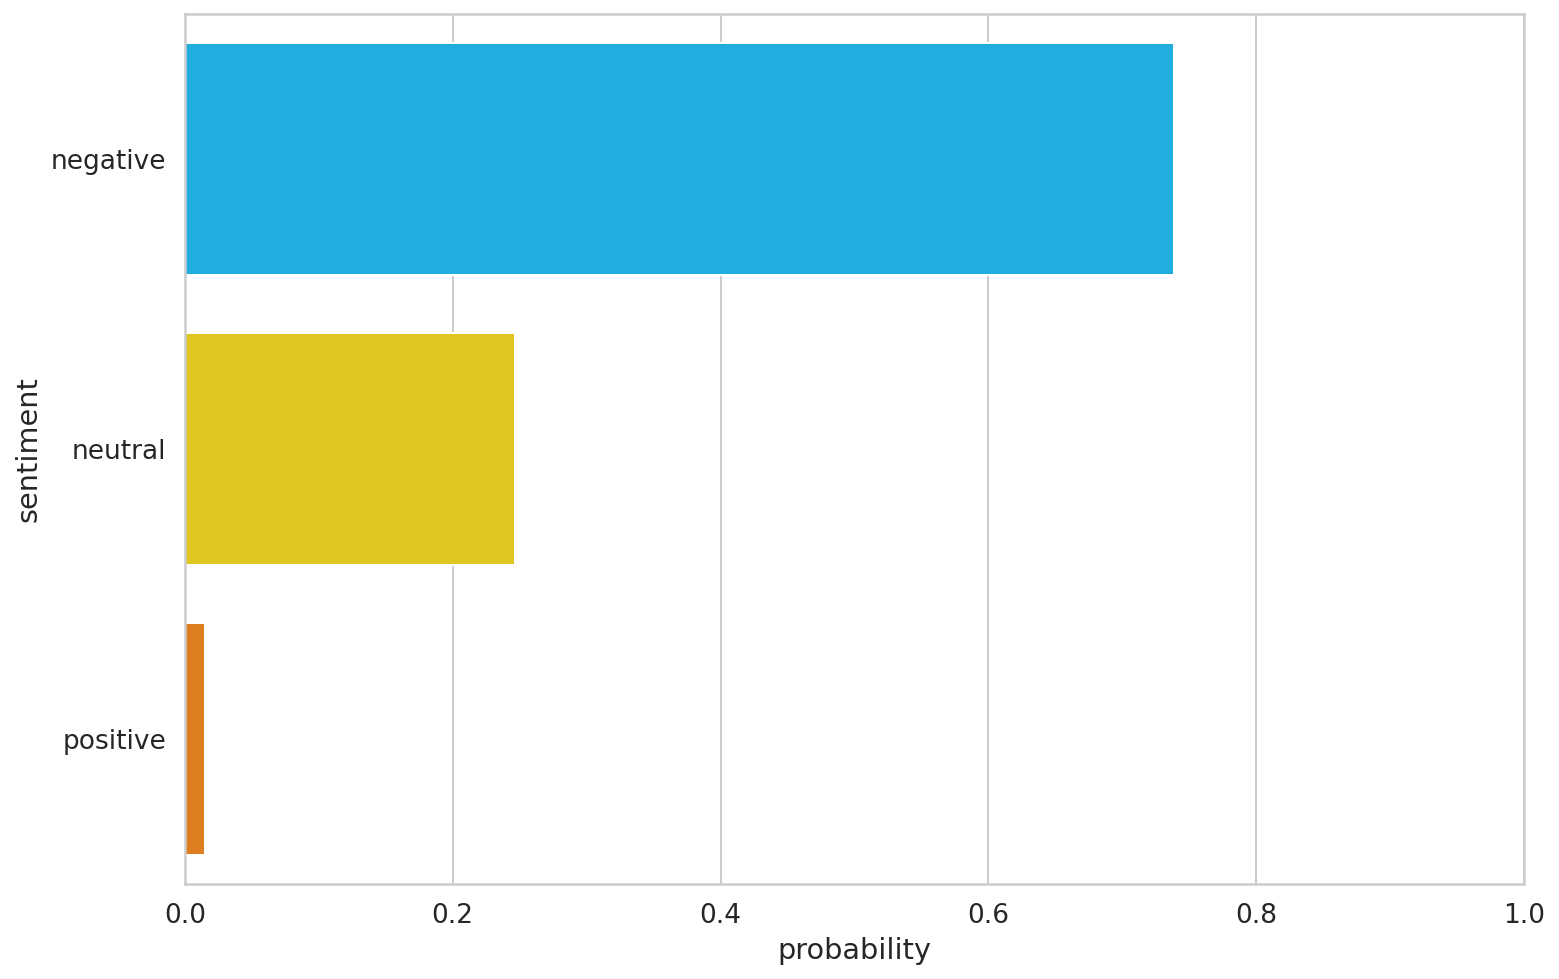

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "Pelayanannya ramah dan memuaskan, banyak pilihan menunya, tempat nyaman bersih Lokasi strategis dekat dengan pusat kota. pokonya the best deh... sukses selalu grand tjokro semakin berjaya.. semoga semakin di depan"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  truncation = True,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Pelayanannya ramah dan memuaskan, banyak pilihan menunya, tempat nyaman bersih Lokasi strategis dekat dengan pusat kota. pokonya the best deh... sukses selalu grand tjokro semakin berjaya.. semoga semakin di depan
Sentiment  : positive
